# **PROBLEM**
Depression as a societal Epidemic

### **Solution:** Depression detection in Social Media posts
Depression is a serious mental health condition affecting millions of people worldwide. It is often undiagnosed and untreated, leading to significant health and economic burdens.

World Health Organization (WHO) reported approximately 280 million people in the world have depression which accounts for roughly 3.8% of the global population, including 5% of adults (4% among men and 6% among women, 50% more common among women than among men), and 5.7% of adults above 60 years of age.​

Social media may play a role in depression, particularly among young people. However, it also offers opportunities for developing tools for early depression detection using analysis of social media language.​


I propose a system for early depression detection in social media posts by analyzing language features and using NLP techniques and machine learning classifiers. It aims to improve performance through careful selection and combination of features from social media dataset.
This system combines features extraction techniques; LDA, TFIDF, and N-grams(unigram, bigram, and trigram) for Natural Language Processing to extract key linguistic features and supervised classification algorithms namely Support Vector Machines and Logistic Regression.

 This document contains source code to the proof of concept of the proposed  system.




# **IMPORTING LIBRARIES**


In [ ]:
# import libraries
import tensorflow as tf
import pandas as pd # Import Pandas for data manipulation using dataframes
import numpy as np # Import Numpy for data statistical analysis


import string
import regex as re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords') #to download stopwords


import matplotlib.pyplot as plt # Import matplotlib for data visualisation
import seaborn as sns # Statistical data visualization
# %matplotlib inline




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **DATA SOURCE**: https://www.kaggle.com/datasets/infamouscoder/depression-reddit-cleaned/data


The dataset was obtained from Kaggle, collected, and processed by Kaggle expert, InFamousCoder in a labeled format such that each row represents a Reddit post and an associated label assigned to it.​

# **IMPORTING DATA**

In [ ]:
# data = pd.read_csv("/depression_dataset_reddit_cleaned.csv")
data = pd.read_csv("./project/depression_dataset_reddit_cleaned.csv")

df = data.copy()

# **VISUALIZING DATA**




In [ ]:
df.shape

(7731, 2)

In [ ]:
df.head()

,clean_text,is_depression
0,we understand that most people who reply immed...,1
1,welcome to r depression s check in post a plac...,1
2,anyone else instead of sleeping more when depr...,1
3,i ve kind of stuffed around a lot in my life d...,1
4,sleep is my greatest and most comforting escap...,1


In [ ]:
df.tail()


,clean_text,is_depression
7726,is that snow,0
7727,moulin rouge mad me cry once again,0
7728,trying to shout but can t find people on the list,0
7729,ughh can t find my red sox hat got ta wear thi...,0
7730,slept wonderfully finally tried swatching for ...,0


In [ ]:
#convert labels to boolean type for the purpose of visualization.
df["is_depression"] = df["is_depression"].astype("boolean")


In [ ]:
sns.set_style()

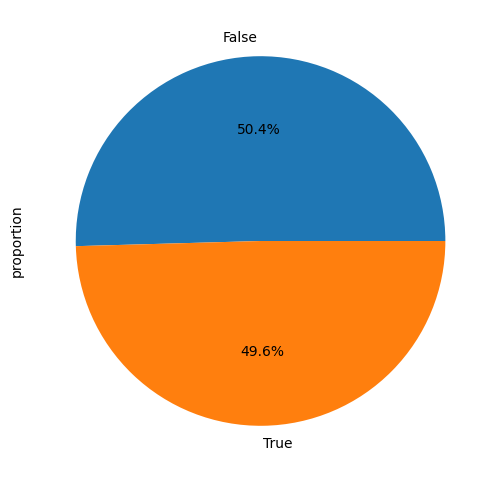

In [ ]:
# plot to show the ratio of depression-indicative post to non-depressive
# indicative posts.
plt.figure(figsize=(12, 6))

df["is_depression"].value_counts(normalize=True).plot(kind="pie", autopct="%1.1f%%")
plt.show()


# **DATA PREPROCESSING**

In [ ]:
#Remove additional non-informative words or tokens in the dataset [1]
def word_standardize(inp_data):
    stop_words = ["wa", "was", "didn","t", "m", "s", "don", "ve","http","tinyurl", "wwww","bit", "ly","com"]
    filter_dt = inp_data.apply(lambda x: " ".join([word for word in x.split() if word not in stop_words]))
    lower_dt = tf.strings.lower(filter_dt)
    nopunc_dt = tf.strings.regex_replace(lower_dt, f"[{string.punctuation}]", "")
    return tf.strings.regex_replace(nopunc_dt, f"[{stopwords.words('english')}]", "").numpy()

# Define a regex pattern to match URLs [2]
url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

# Function to remove URLs
def remove_urls(text):
    return re.sub(url_pattern, '', text)

In [ ]:
df["standardize_words"] = word_standardize(df["clean_text"]) #apply the word_standardize method to the df["clean_text"] column and create a new column with the
#output of the operation
df["standardize_words"] = (df["standardize_words"].str.decode("utf-8")).apply(remove_urls) #apply the remove urls to remove words that match the specified pattern
# df["standardize_words"] = df["standardize_words"].apply(remove_urls)


In [ ]:
#convert label back to floating point type
df["is_depression"] = (df["is_depression"] == True).astype(np.int64)


In [ ]:
#convert back to integer type
# target = df["is_depression"].astype(np.int64)
feature = df["standardize_words"]
# feature = df["clean_text"]


In [ ]:
df

,clean_text,is_depression,standardize_words
0,we understand that most people who reply immed...,1,we understand that most people who reply immed...
1,welcome to r depression s check in post a plac...,1,welcome to r depression check in post a place ...
2,anyone else instead of sleeping more when depr...,1,anyone else instead of sleeping more when depr...
3,i ve kind of stuffed around a lot in my life d...,1,i kind of stuffed around a lot in my life dela...
4,sleep is my greatest and most comforting escap...,1,sleep is my greatest and most comforting escap...
...,...,...,...
7726,is that snow,0,is that snow
7727,moulin rouge mad me cry once again,0,moulin rouge mad me cry once again
7728,trying to shout but can t find people on the list,0,trying to shout but can find people on the list
7729,ughh can t find my red sox hat got ta wear thi...,0,ughh can find my red sox hat got ta wear this ...


# CLASSIFICATION TASK
To estimate the presence of depression, as mentioned the classification techniques; Support Vector Machine(SVM), and Logistic Regression were used to estimate the likelihood of depression from users’ posts. I chose these two algorithms, a simple Logistic Regression and a more sophisticated SVM, because they work well with linearly separable data (text data usually exhibit this) and to establish the importance and impact of proper feature selection and combination compared to the algorithms themselves on the classification tasks.
The classification and evaluation approach in this study involved 3 cate- gories:
* Category 1 : Uses the original TF-IDF(n-grams) features during model training.
* Category 2 : This category applied SVM and Logistic Regression to classify extracted features using the entire pipeline LDA (TF-IDF( n-grams)).
* Category 3 : This category built upon Category 1 by including the original TF-IDF(n-grams) features alongside the LDA(TF-IDF(n-grams)) features during model training.


# **CATEGORY 1**
##TFIDF(unigrams to trigrams)

## **Features Extraction**

### **TFIDF(N-GRAMS)**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=6000, ngram_range=(1, 3), stop_words="english")
X_tfidf = tfidf_vectorizer.fit_transform(feature)


X = pd.concat([pd.DataFrame(X_tfidf.toarray())], axis=1)


X

,0,1,2,3,4,5,6,7,8,9,...,5990,5991,5992,5993,5994,5995,5996,5997,5998,5999
0,0.035843,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04604,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.042379,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.058846,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7726,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
7727,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
7728,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
7729,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


## **Prepare Training and Testing Dataset**

In [ ]:
target

0       1
1       1
2       1
3       1
4       1
       ..
7726    0
7727    0
7728    0
7729    0
7730    0
Name: is_depression, Length: 7731, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.2, random_state=42)
X.shape

(7731, 6000)

In [ ]:
X_train.shape

(6184, 6000)

In [ ]:
X_test.shape

(1547, 6000)

In [ ]:
y_train.shape

(6184,)

In [ ]:
y_test.shape

(1547,)

## **Train Model**

### **SVM**

In [ ]:
from sklearn.svm import SVC


svm_rbf = SVC(kernel="rbf" )
svm_rbf.fit(X_train, y_train)

SVC()

In [ ]:
from sklearn.metrics import accuracy_score

# Evaluate SVM model
y_pred = svm_rbf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9476405946994182


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(y_test, y_pred)
cm

array([[767,  16],
       [ 65, 699]])

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       783
           1       0.98      0.91      0.95       764

    accuracy                           0.95      1547
   macro avg       0.95      0.95      0.95      1547
weighted avg       0.95      0.95      0.95      1547



<Axes: >

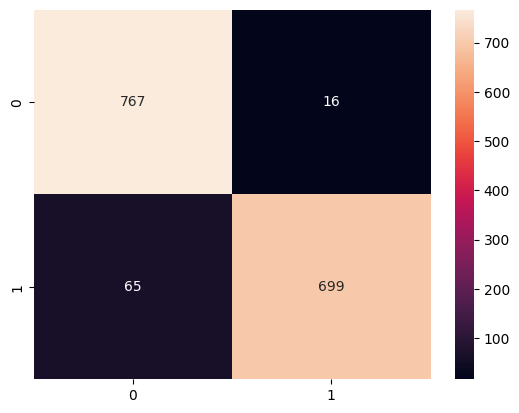

In [ ]:
# plt.figure(figsize=(20,10))

sns.heatmap(cm, annot=True, fmt="d")

### **Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression


In [ ]:
l_reg = LogisticRegression(random_state = 0)
l_reg.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [ ]:
# Evaluate Logistic Regression
y_pred = l_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9444085326438267


In [ ]:

cm = confusion_matrix(y_test, y_pred)
cm

array([[765,  18],
       [ 68, 696]])

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       783
           1       0.97      0.91      0.94       764

    accuracy                           0.94      1547
   macro avg       0.95      0.94      0.94      1547
weighted avg       0.95      0.94      0.94      1547



<Axes: >

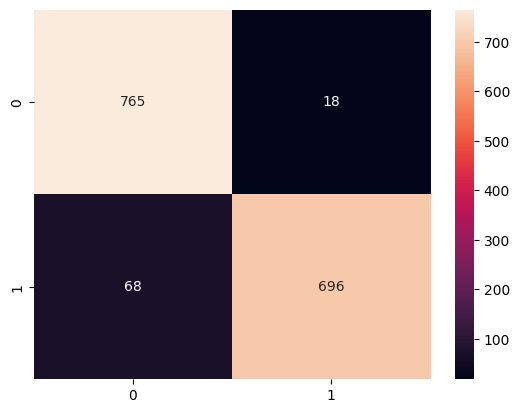

In [ ]:
# plt.figure(figsize=(20,10))

sns.heatmap(cm, annot=True, fmt="d")

# **CATEGORY 2**
## LDA(TFIDF(unigrams to trigrams))

## **Features Selection**

### **TFIDF(N-GRAM)**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer


tfidf_vectorizer = TfidfVectorizer(max_features=6000, ngram_range=(1, 3), stop_words="english")

X_tfidf = tfidf_vectorizer.fit_transform(feature)

X

,0,1,2,3,4,5,6,7,8,9,...,5990,5991,5992,5993,5994,5995,5996,5997,5998,5999
0,0.035843,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04604,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.042379,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.058846,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7726,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
7727,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
7728,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
7729,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


### **LDA**

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation


lda_model = LatentDirichletAllocation(n_components=99, random_state=42, doc_topic_prior=0.01,
                                      topic_word_prior=0.01, learning_method='online', learning_decay=0.7,
                                      learning_offset=10.0, max_iter=10, batch_size=128, evaluate_every=-1,
                                      total_samples=1000000.0, perp_tol=0.1, mean_change_tol=0.001,
                                      max_doc_update_iter=100, n_jobs=None, verbose=0)

X_lda = lda_model.fit_transform(X_tfidf)

In [ ]:
X = pd.concat([pd.DataFrame(X_lda)], axis=1)

## **Prepare Training and Testing Dataset**

In [ ]:
target

0       1
1       1
2       1
3       1
4       1
       ..
7726    0
7727    0
7728    0
7729    0
7730    0
Name: is_depression, Length: 7731, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.2, random_state=42)
X.shape

(7731, 99)

In [ ]:
X_train.shape

(6184, 99)

In [ ]:
X_test.shape

(1547, 99)

In [ ]:
y_train.shape

(6184,)

In [ ]:
y_test.shape

(1547,)

## **Train Model**

### **SVM**

In [ ]:
svm_rbf = SVC(kernel="rbf", )
svm_rbf.fit(X_train, y_train)

SVC()

In [ ]:
# Evaluate SVM model
y_pred = svm_rbf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8823529411764706


In [ ]:

cm = confusion_matrix(y_test, y_pred)
cm

array([[744,  39],
       [143, 621]])

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89       783
           1       0.94      0.81      0.87       764

    accuracy                           0.88      1547
   macro avg       0.89      0.88      0.88      1547
weighted avg       0.89      0.88      0.88      1547



<Axes: >

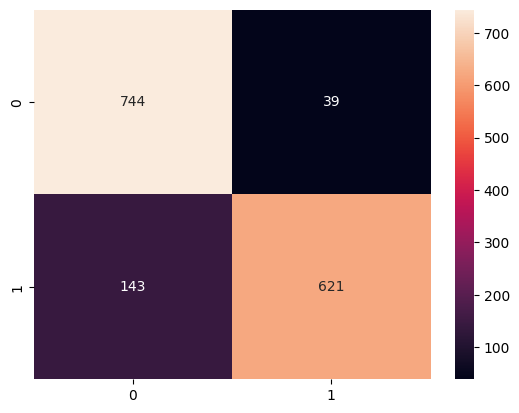

In [ ]:
# plt.figure(figsize=(20,10))

sns.heatmap(cm, annot=True, fmt="d")

### **Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression


In [ ]:
l_reg = LogisticRegression(random_state = 0)
l_reg.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [ ]:
# Evaluate Logistic Regression
y_pred = l_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8442146089204913


In [ ]:

cm = confusion_matrix(y_test, y_pred)
cm

array([[658, 125],
       [116, 648]])

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.84      0.85       783
           1       0.84      0.85      0.84       764

    accuracy                           0.84      1547
   macro avg       0.84      0.84      0.84      1547
weighted avg       0.84      0.84      0.84      1547



<Axes: >

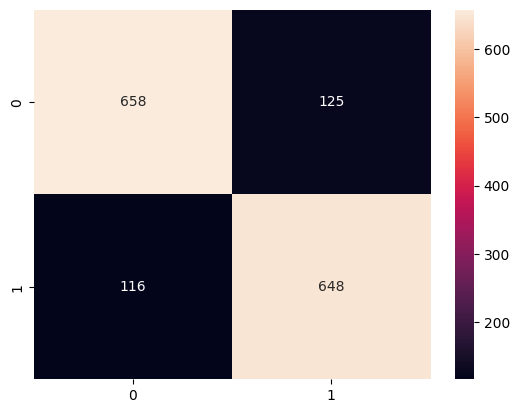

In [ ]:
# plt.figure(figsize=(20,10))

sns.heatmap(cm, annot=True, fmt="d")

# **CATEGORY 3**
# LDA(TFIDF(unigrams to trigrams)) + TFIDF(unigrams to trigrams)

## **Features Selection**

### **TFIDF(N-GRAM)**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer


tfidf_vectorizer = TfidfVectorizer(max_features=6000, ngram_range=(1, 3), stop_words="english")

X_tfidf = tfidf_vectorizer.fit_transform(feature)



X

,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
0,0.000792,0.000792,0.000792,0.000792,0.000792,0.000792,0.000792,0.000792,0.000792,0.000792,...,0.000792,0.000792,0.905360,0.000792,0.000792,0.000792,0.000792,0.000792,0.000792,0.000792
1,0.001091,0.001091,0.001091,0.001091,0.001091,0.001091,0.001091,0.001091,0.001091,0.001091,...,0.001091,0.001091,0.856229,0.001091,0.001091,0.001091,0.001091,0.001091,0.001091,0.001091
2,0.001981,0.001981,0.001981,0.001981,0.001981,0.001981,0.001981,0.001981,0.001981,0.001981,...,0.001981,0.001981,0.738207,0.001981,0.001981,0.001981,0.001981,0.001981,0.001981,0.001981
3,0.001369,0.001369,0.001369,0.001369,0.001369,0.001369,0.001369,0.001369,0.001369,0.001369,...,0.001369,0.001369,0.865792,0.001369,0.001369,0.001369,0.001369,0.001369,0.001369,0.001369
4,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,...,0.001823,0.001823,0.821310,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7726,0.005025,0.005025,0.005025,0.005025,0.005025,0.005025,0.005025,0.005025,0.005025,0.005025,...,0.005025,0.005025,0.005025,0.005025,0.005025,0.005025,0.005025,0.005025,0.005025,0.005025
7727,0.005025,0.005025,0.005025,0.005025,0.005025,0.005025,0.005025,0.005025,0.005025,0.005025,...,0.005025,0.005025,0.507538,0.005025,0.005025,0.005025,0.005025,0.005025,0.005025,0.005025
7728,0.003482,0.003482,0.003482,0.003482,0.003482,0.003482,0.003482,0.003482,0.003482,0.003482,...,0.003482,0.003482,0.658764,0.003482,0.003482,0.003482,0.003482,0.003482,0.003482,0.003482
7729,0.002539,0.002539,0.002539,0.002539,0.002539,0.002539,0.002539,0.002539,0.002539,0.002539,...,0.002539,0.002539,0.651018,0.002539,0.002539,0.002539,0.002539,0.002539,0.002539,0.002539


### **LDA**

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation


lda_model = LatentDirichletAllocation(n_components=182, random_state=42, doc_topic_prior=0.01,
                                      topic_word_prior=0.01, learning_method='online', learning_decay=0.7,
                                      learning_offset=10.0, max_iter=10, batch_size=128, evaluate_every=-1,
                                      total_samples=1000000.0, perp_tol=0.1, mean_change_tol=0.001,
                                      max_doc_update_iter=100, n_jobs=None, verbose=0)

X_lda = lda_model.fit_transform(X_tfidf)

### **COMBINATION: TFIDF(N-GRAMS) + LDA(TFIDF(N-GRAMS))**

In [ ]:
X = pd.concat([pd.DataFrame(X_tfidf.toarray()), pd.DataFrame(X_lda)], axis=1)


## **Prepare Training and Testing Dataset**

In [ ]:
target

0       1
1       1
2       1
3       1
4       1
       ..
7726    0
7727    0
7728    0
7729    0
7730    0
Name: is_depression, Length: 7731, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.2, random_state=42)
X.shape

(7731, 6182)

In [ ]:
X_train.shape

(6184, 6182)

In [ ]:
X_test.shape

(1547, 6182)

In [ ]:
y_train.shape

(6184,)

In [ ]:
y_test.shape

(1547,)

## **Train Model**

### **SVM**

In [ ]:
svm_rbf = SVC(kernel="rbf", )
svm_rbf.fit(X_train, y_train)

SVC()

In [ ]:
# Evaluate SVM model
y_pred = svm_rbf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.962508080155139


In [ ]:

cm = confusion_matrix(y_test, y_pred)
cm

array([[777,   6],
       [ 52, 712]])

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       783
           1       0.99      0.93      0.96       764

    accuracy                           0.96      1547
   macro avg       0.96      0.96      0.96      1547
weighted avg       0.96      0.96      0.96      1547



<Axes: >

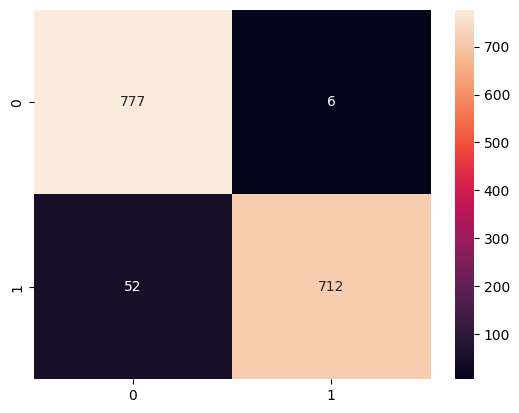

In [ ]:
# plt.figure(figsize=(20,10))

sns.heatmap(cm, annot=True, fmt="d")

### **Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression


In [ ]:
l_reg = LogisticRegression(random_state = 0)
l_reg.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [ ]:
# Evaluate Logistic Regression
y_pred = l_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9560439560439561


In [ ]:

cm = confusion_matrix(y_test, y_pred)
cm

array([[768,  15],
       [ 53, 711]])

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       783
           1       0.98      0.93      0.95       764

    accuracy                           0.96      1547
   macro avg       0.96      0.96      0.96      1547
weighted avg       0.96      0.96      0.96      1547



<Axes: >

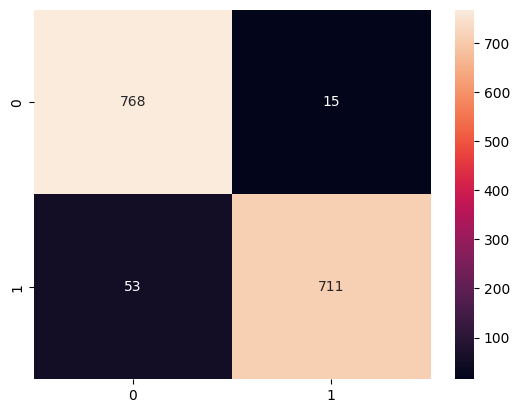

In [ ]:
# plt.figure(figsize=(20,10))

sns.heatmap(cm, annot=True, fmt="d")

# CONCLUSION

I have developed a simple and intuitive system for depression detection based on feature extraction techniques (LDA, TFIDF, and n-grams), evaluated these features in Isolation and combination, fed them to the SVM and Logistic regression algorithms in categories, and produced a performance comparison of these categories. I obtained excellent results with these categories and based on my findings, category 3 emerged as the best approach with 96% accuracy, 0.96 f1 score, 0.96 precision, and 0.96 recall. This category improved accuracy by approximately 1% over the best result of Category 1 and 8% over the best result of Category 2. From this experiment’s result, it is clear that the impact of feature combination on the classification result outweighs the choice of the classifier used. This system has the potential to be very valuable to individuals and communities. For instance, social media platforms or blogs could integrate this solution into their system to help diagnose depressed users and suggest mental health services ads or meetup groups to make help easily accessible to these users.

However, one limitation is the reliance on manually engineered features, which may result in the omission or partial capture of key aspects of the text due to the limitations of the NLP techniques employed. Another is, it does not explore all possible parameter values for the feature extraction techniques employed.

